# Python code of Gibbs sampling model for family test result Covid problem

In [12]:
# import neccessary libraries
import numpy as np
import random
from datetime import datetime
from scipy.stats import beta
from sklearn.metrics import accuracy_score
import winsound
import matplotlib.pyplot as plt
from scipy import spatial
duration = 1000  # milliseconds
freq = 440  # Hz

In [13]:
# function to count the number of infected neighbores of i at t:
def CNbr(G,X,n,T):
    C=np.zeros((T,n))
    for t in range(T):
        C[t]=G[t].dot(X.T[t])
    return C.T

In [3]:
# Function to obtain the very initial sample of X, using forwad sampling:
def Forward_Sampling(T,n,G,F,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    p0=P
    p1=np.round(1-P,1)
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))  
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    infected_neighbore=CNbr(G,X,n,T)
    for t in range(T-1):
        cf=F.dot(X.T[t])
        for i in range(n):
            c=infected_neighbore[i,t]
            if X[i,t]==0:
                p0=(1-alpha_-beta_*c-betaf*cf[i])
                p1=(alpha_+beta_*c+betaf*cf[i])
            else:
                p0=(gama_)
                p1=(1-gama_)
            if p0+p1==0:
                l=0.5
            else:
                l=p1/(p0+p1)
            X[i,t+1]=np.random.binomial( 1, l,size=None)
    return X

In [4]:
# function to calculate transition probability of individual j from time step t to t+1:
def transition(X,t,G,F,j,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    c=G[t].dot(X.T[t])[j]
    number_of_infected_members_in_family=F.dot(X.T[t])[j]
    k=X[j,t]-2*X[j,t+1]
    if k==0:
        return 1-alpha_-beta_*c-betaf*number_of_infected_members_in_family
    elif k==-2:
        return alpha_+beta_*c+betaf*number_of_infected_members_in_family
    elif k==1:
        return gama_
    else:
        return 1-gama_
    

In [446]:
# function to sample X, using Gibbs Sampling:
def Sample_hidden_state(X,G,F,unique_rows,Y,param,t):
    pos_probs=np.zeros((n,T))
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    theta_0_=param[4]
    theta_1_=param[5]
    
    for i in range(n):
        p_0,p_1=0,0
        if t==0:
            p_0,p_1=P,1-P
        else:
            p_0,p_1=1,1
        pow0=1-Y[i,t]
        pow1=Y[i,t]
        number_of_members_in_family=np.sum(unique_rows[family_index(i,unique_rows)])
        X[i,t]=0
        number_of_infected_members_in_family0=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family0=number_of_members_in_family-number_of_infected_members_in_family0
        # emission probability when sample is X[i,t]=0:
        p_0=(1/number_of_members_in_family)*p_0*((1-theta_0_)*number_of_healthy_members_in_family0+(1-theta_1_)*number_of_infected_members_in_family0)**pow0*(theta_1_*number_of_infected_members_in_family0+theta_0_*number_of_healthy_members_in_family0)**pow1
        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
    
        if t!=0:
            # transition probability of i from t-1 to t, when sample is X[i,t]=0:
            if X[i,t-1]==0:
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family0)
            else:
                p_0=p_0*gama_
        # emission probability when sample is X[i,t]=1:
        X[i,t]=1
        number_of_infected_members_in_family1=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family1=number_of_members_in_family-number_of_infected_members_in_family1
        p_1=(1/number_of_members_in_family)*p_1*((1-theta_0_)*number_of_healthy_members_in_family1+(1-theta_1_)*number_of_infected_members_in_family1)**pow0*(theta_1_*number_of_infected_members_in_family1+theta_0_*number_of_healthy_members_in_family1)**pow1

        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
        if t!=0:
            # transition probability of i, when sample is X[i,t]=1:
            if X[i,t-1]==0:
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family0)
            else:
                p_1=p_1*(1-gama_)
        family_members=unique_rows[family_index(i,unique_rows)]
        # transition probability of i's neighbores and family members, from t to t+1:
        if t!=T-1:        
            X[i,t]=0
            for j in np.where(family_members==1)[0]:
                p_0=p_0*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                if j!=i:
                    p_0=p_0*transition(X,t,G,F,j,param)
            X[i,t]=1
            for j in np.where(family_members==1)[0]:
                p_1=p_1*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_1=p_1*transition(X,t,G,F,j,param)
        
        if p_0+p_1==0:            
            l=0.5
        else:
            l=p_1/(p_0+p_1)
        if (l<0)|(l>1): 
            print(p_0,p_1)
        X[i,t]=np.random.binomial( 1,  l,size=None)    
        pos_probs[i,t]=p_1
    return X ,pos_probs   

In [259]:
def Accuracy_(X,X_):
    Xflat = np.hstack(X)
    X_flat = np.hstack(X_)
    result=accuracy_score(Xflat, X_flat,normalize=True)
    return result

In [447]:
# Gibbs sampling to obtain X, as new sample of posterior distribution:
def Calculate_X(K,T,X,G,F1,Y,param):
    accuracy=[]
    myList =[]
    for k in range(K):
        print(k)
        for t in range(T):
            hidden_states=Sample_hidden_state(X,G,F,unique_rows,Y,param,t)
            X=hidden_states[0]
            pos_probs=hidden_states[1]
        accuracy.append(np.sum(X))
    myList = list(range(K))
    iteration=np.array(myList)
    Accuracy=np.array(accuracy)
    
    return X , iteration  ,  Accuracy   ,pos_probs       

In [8]:
# function to sample new parameters and update parameters:
def Params(R,G,F,X,n,T,Y,hyper_param):
    
    a_alpha=hyper_params[0]
    b_alpha=hyper_params[1]
    a_beta=hyper_params[2]
    b_beta=hyper_params[3]
    a_betaf=hyper_params[4]
    b_betaf=hyper_params[5]
    a_gama=hyper_params[6]
    b_gama=hyper_params[7]
    a_teta0=hyper_params[8]
    b_teta0=hyper_params[9]
    a_teta1=hyper_params[10]
    b_teta1=hyper_params[11]
      
    TP=np.sum(np.multiply(unique_rows.dot(X),YF))
    FP=np.count_nonzero(unique_rows.dot(X)-YF==-1)
    
    infected_neighbore=np.array(CNbr(G,X,n,T))
    a_alpha, b_alpha=a_alpha +  np.count_nonzero(R==0) , b_alpha +np.count_nonzero(X==0)- np.count_nonzero(R==0)
    alpha_=Sample_alpha(a_alpha, b_alpha)
    a_beta,b_beta=a_beta + np.count_nonzero(R==2) , b_beta +np.sum(np.multiply((1-X),infected_neighbore))-np.count_nonzero(R==2)
    beta_=Sample_beta(a_beta,b_beta)
    a_betaf ,b_betaf=a_betaf + np.count_nonzero(R==3) , b_betaf +np.sum(np.multiply((1-X),F.dot(X)))-np.count_nonzero(R==3)
    betaf=Sample_betaf(a_betaf ,b_betaf)
    while alpha_>beta_:
        alpha_=Sample_alpha(a_alpha, b_alpha)
        beta_=Sample_beta(a_beta, b_beta)
    while beta_>betaf:
        betaf=Sample_betaf(a_betaf, b_betaf)
    gama_=Sample_gama(a_gama +np.count_nonzero((X[:,:-1]-X[:,1:])==1), b_gama+np.sum(X)-np.count_nonzero((X[:,:-1]-X[:,1:])==1))
    theta_0_=Sample_theta0( a_teta0+FP,b_teta0+np.count_nonzero((unique_rows.dot(X))==0)-FP)
    theta_1_=Sample_theta1( a_teta1+TP,b_teta1+np.sum(unique_rows.dot(X))-TP)
    
    R=R_(G,X,params)
    param=[alpha_,beta_,betaf,gama_,theta_0_,theta_1_]
    return param,R

# Functions to sample from beta distribution


In [5]:
def Sample_alpha(a_alpha, b_alpha):
    for i in beta.rvs(a_alpha, b_alpha, size=20000):
        print("0",i,a_beta,b_beta)
        if (i>0.001)&(i<0.2):
            alpha_=round(i,3)
            break
    return alpha_        


In [6]:
def Sample_beta(a_beta, b_beta):
    for i in beta.rvs(a_beta, b_beta, size=10000):
        print("1",i,a_beta,b_beta)
        if (i>0.001)&(i<0.0451):
            beta_=round(i,4)
            break
    return beta_        

In [7]:
def Sample_betaf(a_betaf, b_betaf):
    for i in beta.rvs(a_betaf, b_betaf, size=10000):
        print("2",i,a_betaf, b_betaf)
        if (i>0.002)&(i<0.5):
            betaf=round(i,4)
            break
    return betaf        

In [8]:
def Sample_gama(a_gama,b_gama):
    for i in beta.rvs(a_gama, b_gama, size=10000):
        print("3",i,a_gama,b_gama) 
        if (i>0.1)&(i<0.5):
            gama_=round(i,3)
            break
    return gama_  

In [9]:
def Sample_theta0(a_teta0, b_teta0):
    for i in beta.rvs(a_teta0, b_teta0, size=10000):
        print("4",i,a_teta0,b_teta0)
        if (i>0.01)&(i<0.51):
            theta_0_=round(i,3)
            break
    return theta_0_  

In [10]:
def Sample_theta1(a_teta1, b_teta1):
    for i in beta.rvs(a_teta1, b_teta1, size=10000):
        print("5",i,a_teta1,b_teta1)
        if 0.990>i>0.5:
            theta_1_=round(i,3)
            break
    return theta_1_  

In [ ]:
#def Sample_alpha(a_alpha, b_alpha):
    
    return beta.rvs(a_alpha, b_alpha, size=1)[0]        


In [ ]:
#def Sample_beta(a_beta, b_beta):
    return beta.rvs(a_beta, b_beta, size=1)[0]       

In [ ]:
#def Sample_betaf(a_betaf, b_betaf):
     return beta.rvs(a_betaf, b_betaf, size=1)[0]        

In [ ]:
#def Sample_gama(a_gama,b_gama):
    
    return beta.rvs(a_gama, b_gama, size=1)[0]  

In [ ]:
#def Sample_theta0(a_teta0, b_teta0):
    return beta.rvs(a_teta0, b_teta0, size=1)[0]  

In [ ]:
#def Sample_theta1(a_teta1, b_teta1):
    
    return beta.rvs(a_teta1, b_teta1, size=1)[0]

In [255]:
# function to add noise to observation vector, in order to test the model performance:
def add_noise(YF,noise_percent):
    number_of_families=YF.shape[0]
    YF_noisey=np.copy(YF)
    index=random.sample(range(0,number_of_families*T ), int(number_of_families*T*noise_percent))
    for j in index:
        i=int(j/T)
        t=j-i*T
        YF_noisey[i,t]=(1+YF[i,t])*(1-YF[i,t])
    return YF_noisey      

In [16]:
# funtion to retun related family index of individual i:
def family_index(i,unique_rows):
    for j in range(n):
        if unique_rows[j,i]==1:
            return j

In [17]:
# function to define auxiliary variable R_(n,t):
def R_(G,X,params):
    alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
    infected_neighbore=np.array(CNbr(G,X,n,T))
    R=np.zeros((n,T))+1
    for i in range(n):
        for t in range(T-1):
            c=int(infected_neighbore[i,t])
            cf=int(F.dot(X.T[t])[i])
            pr_a=alpha_/(alpha_+beta_*c+betaf*cf)
            pr_b=beta_/(alpha_+beta_*c+betaf*cf)
            pr_bf=betaf/(alpha_+beta_*c+betaf*cf)
            v=np.random.multinomial(1, [pr_a]+[pr_b]*c+[pr_bf]*cf)
            if (X[i][t]==0)&(X[i][t+1]==1):
                if v[0]==1:
                    R[i,t]=0
                elif (cf!=0):
                    if ((v[-cf:]==1).any()):
                        R[i,t]=3
                else:    
                    R[i,t]=2
    return R

In [18]:
# function to estimate YF from estimated X:
def estimate_Y(Family,X,params):
    theta_0_=params[4]
    theta_1_=params[5]
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None)
    return YF

In [1]:
# Function to generates synthetic dataset
def Synthetic_Data(n,T,y,params,number_families):
    alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    # Random social network
    G=[]
    for j in range(T):
        g=np.identity(n,dtype=int)
        for i in range(n):
            indx=np.random.choice(range(i,n), y)
            for inx in indx:
                g[i,inx]=1  
                g[inx,i]=1
        G.append(g)
    G=np.array(G)
    # Synthetize Family matrix:
    a=list(range(n))
    Family=np.identity(n,dtype=int)
    for i in range(1,number_families):
        number_family_members=np.random.randint(2, 5)
        inx=random.sample(list(a), number_family_members)
        a=set(a).difference(inx)
        for j in inx:
            for k in inx:
                Family[j,k]=1  
    G=G-Family
    G=G+np.identity(n,dtype=int)
    G = np.where(G <0, 0, G)
    # Synthetize X, using params,G, Family and transition probability:
    for t in range(T-1):
        for i in range(n):
            infected_neighbore=CNbr(G,X,n,T)
            cf=int(Family.dot(X.T[t])[i])
            c=infected_neighbore[i,t]
            if X[i,t]==0:
                p0=1-alpha_-beta_*c-betaf*cf
                p1=alpha_+beta_*c+betaf*cf
            else:
                p0=gama_
                p1=1-gama_
            if p0+p1==0:
                l=0.5
            else:
                l=p1/(p0+p1)
            X[i,t+1]=np.random.binomial( 1, l,size=None) 

    # Synthetize Y, using params, G, X, emission probability:
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None) 
    return G,YF,X,Family           

In [2]:
# function to sample infection and emission parameters(alpha,beta,betaf,gama,teta0,teta1)
def initialize_parameters(hyper_params):
    a_alpha=hyper_params[0]
    b_alpha=hyper_params[1]
    a_beta=hyper_params[2]
    b_beta=hyper_params[3]
    a_betaf=hyper_params[4]
    b_betaf=hyper_params[5]
    a_gama=hyper_params[6]
    b_gama=hyper_params[7]
    a_teta0=hyper_params[8]
    b_teta0=hyper_params[9]
    a_teta1=hyper_params[10]
    b_teta1=hyper_params[11]
    alpha_=Sample_alpha(a_alpha, b_alpha)
    beta_=Sample_beta(a_beta, b_beta)
    betaf=Sample_betaf(a_betaf, b_betaf)
    while alpha_>beta_:
        alpha_=Sample_alpha(a_alpha, b_alpha)
        beta_=Sample_beta(a_beta, b_beta)
    while beta_>betaf:
        betaf=Sample_betaf(a_betaf, b_betaf)
    gama_=Sample_gama(a_gama,b_gama)
    theta_0_=Sample_theta0(a_teta0, b_teta0)
    theta_1_=Sample_theta1(a_teta1, b_teta1)
    params=np.array([alpha_,beta_,betaf,gama_,theta_0_,theta_1_])
    return params

In [3]:
# initialize parameters for beta distributions:
a_alpha=1
b_alpha=100
a_beta=1
b_beta=100
a_betaf=1
b_betaf=50
a_gama=1
b_gama=2
a_teta0=1
b_teta0=100
a_teta1=100
b_teta1=1
# infection rate
P=.99
epcilon=0.0001
hyper_params=[a_alpha,b_alpha,a_beta,b_beta,a_betaf,b_betaf,a_gama,b_gama,a_teta0,b_teta0,a_teta1,b_teta1]

In [11]:
# parameter initialization:
params=initialize_parameters(hyper_params)
params

NameError: name 'beta' is not defined

In [417]:
# Generate synthetic data,G ,Y:
n,T,y=100,100,5
number_families=33
synthetic_data=Synthetic_Data(n,T,y,params,number_families)
G,YF,X_true,Family =synthetic_data[0],synthetic_data[1],synthetic_data[2],synthetic_data[3]

In [418]:
np.sum(X_true)

475.0

In [419]:
F=Family

In [420]:
unique_rows = np.unique(F.T, axis=0)

# Adding noise to YF:

In [421]:
%store YF
%store params
%store X_true

Stored 'YF' (ndarray)
Stored 'params' (list)
Stored 'X_true' (ndarray)


In [422]:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF[j,:]

In [423]:
U=1
K=40
J=1

In [451]:
# Main code to run entire Gibbs sampling algorithm U times:
def Gibbs_train(hyper_params,T,n,G,F,Y,U,K,J):
    
    a_alpha=hyper_params[0]
    b_alpha=hyper_params[1]
    a_beta=hyper_params[2]
    b_beta=hyper_params[3]
    a_betaf=hyper_params[4]
    b_betaf=hyper_params[5]
    a_gama=hyper_params[6]
    b_gama=hyper_params[7]
    a_teta0=hyper_params[8]
    b_teta0=hyper_params[9]
    a_teta1=hyper_params[10]
    b_teta1=hyper_params[11]
    acc=[]  
    XX=[]
    for j in range(J):
        params=initialize_parameters(hyper_params)
        print(params)
        X=Forward_Sampling(T,n,G,F,params)
        print("Forward_Sampling",j,"\n","\n")
        print("Start Gibbs Sampling:")
        mylist=[]
        accuracy=[]
        for i in range(U):
            print("************************************************ Iteration",i,"************************************************")
            print("Current Parameters:",params)
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Current Time is :", current_time)
            cal=Calculate_X(K,T,X,G,F,Y,params)
            X=cal[0]
            R=R_(G,X,params)
            prm=Params(R,G,F,X,n,T,Y,hyper_params)
            params=prm[0]
            R=prm[1]
        label="Sample:"+str(j)
        iteration=cal[1]
        Accuracy=cal[2]
        pos_probs=cal[3]
        plt.figure()
        plt.plot(iteration,Accuracy ,label=label) 
        plt.legend()
        XX.append(X)    
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
    winsound.Beep(freq, duration) 
    return params, np.array(XX) ,pos_probs

In [449]:
X_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

0 0.0008430803620148091 1 100
0 0.006515129241386217 1 100
1 0.01973595204341797 1 100
2 0.003167465549777507 1 50
2 0.014381688031010973 1 50
2 0.0025995622447912044 1 50
2 0.011566219196492708 1 50
2 0.003512490690446583 1 50
2 0.012958744110806714 1 50
2 0.07024537007831529 1 50
3 0.46849762158635555 1 2
4 0.013555362664268237 1 100
5 0.9951797180411108 100 1
5 0.9926504509808505 100 1
5 0.9631837654691786 100 1
[0.007  0.0197 0.0702 0.468  0.014  0.963 ]
Forward_Sampling 0 
 

Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Parameters: [0.007  0.0197 0.0702 0.468  0.014  0.963 ]
Current Time is : 09:30:54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0 0.009869475323700106 1 100
1 0.01945493299748178 61 3010.0
2 0.034939159739369716 21 546.0
3 0.4974375013123232 167 159.0
4 0.0796621388515713 294 3506
5 0.8124222008660782 345.0 

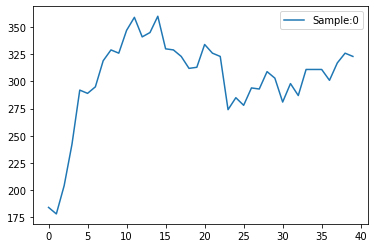

In [452]:
Train=Gibbs_train(hyper_params,T,n,G,F,Y,U,K,J)

In [453]:
trained_params=Train[0]

In [454]:
pos_probs=Train[2]

In [455]:
np.sum(X_true)

475.0

In [456]:
%store -r X_true
accuracy=[]
for j in range(J):
    X=Train[1][j]
    accuracy.append(Accuracy_(X,X_true))
    print(np.count_nonzero(np.multiply(X,X_true)))
print(accuracy)    

78
[0.9358]


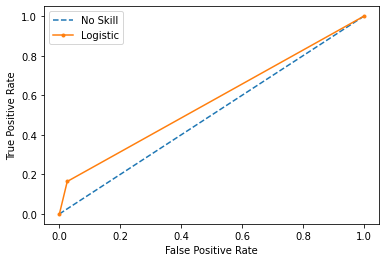

In [461]:
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(np.hstack(X_true), np.hstack(X))
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Test the trained model:

In [431]:
# Main code to run entire Gibbs sampling algorithm U times:
def Gibbs_test(param,T,n,G,F,Y,K,J):
    
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    theta_0_=param[4]
    thata_1_=param[5] 
    acc=[]  
    XX=[]
    for j in range(J):
        
        print(params)
        X=Forward_Sampling(T,n,G,F,params)
        print("Forward_Sampling",j,"\n","\n",X)
        print("Start Gibbs Sampling:")
        X=Calculate_X(K,T,X,G,F,Y,params)[0]
        
        XX.append(X)    
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
    winsound.Beep(freq, duration) 
    return np.array(XX)

In [256]:
noise_percent=.1
YF_noisey=add_noise(YF,noise_percent)

In [180]:
params=trained_params

In [262]:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF_noisey[j,:]

In [263]:
Test=Gibbs_test(params,T,n,G,F,Y,K,J)

[0.005, 0.0116, 0.0138, 0.209, 0.11, 0.697]
Forward_Sampling 0 
 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Start Gibbs Sampling:
Current Time is : 09:47:35
[0.005, 0.0116, 0.0138, 0.209, 0.11, 0.697]
Forward_Sampling 1 
 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Start Gibbs Sampling:
Current Time is : 10:52:03


In [264]:
Test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [432]:
accuracy=[]
for j in range(J):
    YF_=estimate_Y(Family,Test[j],params)
    accuracy.append(Accuracy_(YF_,YF))
    print(np.count_nonzero(np.multiply(YF_,YF))/np.sum(YF))
print(accuracy)    

0.11324376199616124
[0.7885]


In [266]:
YF_noisey

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [267]:
estimate_Y(Family,X,params)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Test the trained model:

In [331]:
accuracy=[]
for j in range(J):
    YF_=estimate_Y(Family,Train[1][j],params)
    accuracy.append(Accuracy_(YF_,YF))
print(accuracy)    

[0.6145714285714285]


In [467]:
y_test=np.hstack(X_true)

In [468]:
y_score=np.stack(pos_probs)

In [463]:
y_test=label_binarize(y_test, classes=[0, 1])

In [464]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [470]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [471]:
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

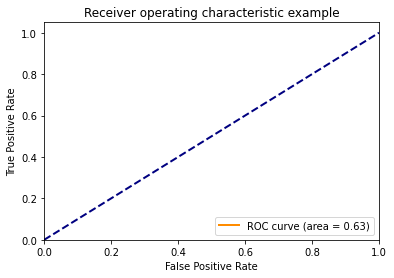

In [472]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [301]:
label_binarize(YFflat, classes=[0, 1])

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [359]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [380]:
y 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [389]:
y = np.hstack(YF)
y.shape

(3500,)

In [381]:
y = label_binarize(y, classes=[0, 1,2])
y.shape

(150, 3)

In [382]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [384]:
from sklearn.preprocessing import label_binarize


array([[1, 0, 0, 0],
       [0, 0, 1, 0]])

In [394]:
z=[1,4]

In [404]:
label_binarize([0,0,1,1], classes=[0,1])

array([[0],
       [0],
       [1],
       [1]])

In [395]:
z.shape

AttributeError: 'list' object has no attribute 'shape'

In [393]:
h

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])